In [ ]:
import torch
import torchvision
#import skimage.io as io
import numpy as np
import torchvision.transforms as t
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import torchvision.models as model
from torchsummary import summary

#from sklearn.metrics import accuracy_score

torch.cuda.set_device(0)
#device=torch.device(#"cuda" if torch.cuda.is_available() else "cpu")
#print("device= ",device)


train_path="/content/drive/MyDrive/HUGA_IMG_ALL_VALUE/training"#"/content/drive/MyDrive/HUGA_HEAT_MAP_IMG/training" MHEALTH_IMG HUGA_HEAT_SEC_IMG_1
test_path="/content/drive/MyDrive/HUGA_IMG_ALL_VALUE/validation"#"/content/drive/MyDrive/MENTALHEALTH_HEAT_MAP_IMG/validation"
val_path="/content/drive/MyDrive/HUGA_IMG_ALL_VALUE/validation"#"/content/drive/MyDrive/MENTALHEALTH_HEAT_MAP_IMG/validation"
#plot_path="/content/drive/MyDrive/HUGA_IMG_ALL_VALUE_RESULTT"#"/content/drive/MyDrive/HUGA_HEATMAP_RESULT"HUGA_RESULT MHEALTH_RESULT
snapshot_path="/content/drive/MyDrive/HUGA_IMG_ALL_VALUE_RESULT"#"/content/drive/MyDrive/MENTAL_HEALTH_HEATMAP_RESULT"

#model_name='resnet18_4'
#"loss_"+model_name+".png"
#/content/drive/MyDrive/HUGA_IMG_ALL_VALUE_RESULT/huga_mobilenet_v3_large__features.csv
model_name='huga_mobilenet_v3_large_final' 
feature_fileName= snapshot_path+'/'+model_name+'__features.csv'
label_fileName= snapshot_path+'/'+model_name+'__labels.csv'
plot_path=snapshot_path+"/loss_"+model_name+".png"




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#set_proper name

batch_s = 18
# For Resnet resize 224 for googlenet it is 256, inception_v3 299
transform=t.Compose([t.Resize((224,224)),
                    # t.RandomCrop((299,224)),
                     t.RandomHorizontalFlip(),
                     t.RandomVerticalFlip(),
                     t.RandomAffine(degrees=(-180,180), translate=(0.1,0.1), scale=(0.9,1.1), shear=(-5,5)),
                     t.ToTensor()])
dset_train=torchvision.datasets.ImageFolder(root=train_path,transform=transform)
# For Resnet resize/efficient 224 for googlenet it is 256
test_trans=t.Compose([t.Resize((224,224)),t.ToTensor()])
#dset_test=torchvision.datasets.ImageFolder(root=test_path,transform=test_trans)
dset_val=torchvision.datasets.ImageFolder(root=val_path,transform=test_trans)

train_loader=torch.utils.data.DataLoader(dset_train,batch_size=batch_s,shuffle=True,num_workers=18)#,drop_last=True)
val_loader=torch.utils.data.DataLoader(dset_val,batch_size=batch_s,shuffle=False,num_workers=18)#,drop_last=True)
#test_loader=torch.utils.data.DataLoader(dset_test,batch_size=batch_s,num_workers=16)#, drop_last=True)

num_classes = 18
#net=model.googlenet()

############################## MODEL ########################################






#models = torchvision.models.resnet18(pretrained=True)

#models = torchvision.models.googlenet(pretrained=True)
models = torchvision.models.efficientnet_b0(pretrained=True)

print(models)
#models = torchvision.models.mobilenet_v3_large(pretrained=True)
#num_ftrs = models.classifier[1].in_features
#models.classifier[1] = nn.Linear(num_ftrs, num_classes)

#net.fc = nn.Linear(net.fc.in_features,num_classes)




class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    img_modules = list(models.children())[:-1]
    self.ModelA = nn.Sequential(*img_modules)
    self.relu = nn.ReLU()
    self.Linear3 = nn.Linear(1280, num_classes , bias = True) # for resnet 512 for google net 1024 inception_v3 2048 efficient 1280  mobile 960

  def forward(self, x):
    x = self.ModelA(x) # N x 512 x 1 x 1
    x1 = torch.flatten(x, 1) # N x 512
    x2 = self.Linear3(x1)
   

    return  x1, x2







#net.fc=nn.Linear(1024,2,True)
net = MyModel()
net=net.cuda()
criterion=nn.CrossEntropyLoss()
params = net.parameters()
optimizer=torch.optim.Adam(net.parameters())
model_name1 = model_name

load_model=snapshot_path+'/model_'+model_name+'.pt'
loaded_flag=False
if os.path.exists(load_model):
    checkpoint=torch.load(load_model)
    net.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    print("model loaded successfully")
    print('starting training after epoch: ',checkpoint['epoch'])
    loaded_flag=True
    

def plot(val_loss,train_loss):
    plt.title("Loss after epoch: {}".format(len(train_loss)))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train_loss")
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation_loss")
    plt.legend()
    plt.savefig(plot_path)
    #plt.figure()
    plt.close()



val_interval=1
#max_acc = 0
min_loss=99999
val_loss_gph=[]
train_loss_gph=[]
val_loss_my=[]
train_loss_my=[]


if loaded_flag:
    min_loss=checkpoint['loss']
    val_loss_gph=checkpoint["val_graph"]
    train_loss_gph=checkpoint["train_graph"]


########################## TRIAN ##################

def train(epoch=5):
  i=0
  max_acc = 0
  global min_loss
  flag=True
  while i+1<=epoch and flag:
    print("Epoch {}".format(i+1 if not loaded_flag else i+1+checkpoint['epoch']))
    train_loss=0.0
    i+=1
    data1 = []
    correct=total=0
    #net = net.train()
    for (image,label) in train_loader:
      net.train()
      optimizer.zero_grad()
      outputs1, outputs2=net(image.cuda())
      #data1.append(outputs1)
      loss=criterion(outputs2 ,label.cuda())
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*image.size(0)
      _, predicted = torch.max(outputs2.data, 1)
      total += label.size(0)
      correct += (predicted == label.cuda()).sum().item()
    print("Train accuracy", (100*correct/total))
    train_loss_gph.append(train_loss/len(dset_train))
    train_loss_my.append(train_loss/len(dset_train))
    #net = net.eval()
    
    if (i+1)%val_interval==0 or (i+1)==epoch:
        net.eval()
        with torch.no_grad():
          val_loss=val_acc=0
          correct=total=0
          #max_acc = 0
          for (img_v,lab_v ) in val_loader:
            output_v1, output_v2=net(img_v.cuda())
            #data1.append(output_v1)
            #val_loss+=criterion(output_v2,lab_v.cuda())
            val_loss+=criterion(output_v2,lab_v.cuda())*img_v.size(0)
            _, predicted = torch.max(output_v2.data, 1)
            total += lab_v.size(0)
            correct += (predicted == lab_v.cuda()).sum().item()
          print("Val accuracy", (100*correct/total))
          val_acc = 100*correct/total
          val_loss_gph.append(val_loss/len(dset_val))
          
        
          if max_acc<val_acc:#min_loss>val_loss:
            state={
                "epoch":i if not loaded_flag else i+checkpoint['epoch'],
                "model_state":net.cpu().state_dict(),
                "optimizer_state":optimizer.state_dict(),
                "loss":min_loss,
                "train_graph":train_loss_gph,
                "val_graph":val_loss_gph,
            }
            
            #min_loss=val_loss
            max_acc=val_acc
            torch.save(state,os.path.join(snapshot_path,"model_"+model_name+'.pt'))
            net.cuda()
          print("validation loss : {:.6f} ".format(val_loss/len(dset_val)))
          val_loss_val=val_loss/len(dset_val)
          val_loss_my.append(float("{:.6f}".format(val_loss/len(dset_val)).strip()))
          
    #plot(val_loss_gph,train_loss_gph)
    print("Train loss : {:.6f}".format(train_loss/len(dset_train)))
    if i==epoch:
      flag=False
      break
  
train(0)


#print("validation MIN loss obtained: {:.6f}".format(min_loss))
net=net.eval()
correct = 0
total = 0
data1 = []
with torch.no_grad():
      for data in train_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data1.append(outputs1)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
      100 * correct / total))

#print("validation MIN loss obtained: {:.6f}".format(min_loss))
net=net.eval()
correct = 0
total = 0
data2 = []
with torch.no_grad():
      for data in val_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data2.append(outputs1)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
      100 * correct / total))
#print(train_loss_gph)

plot(val_loss_my,train_loss_my)
'''
net=net.eval()
correct = 0
total = 0
data3 = []
with torch.no_grad():
      for data in test_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data3.append(outputs1)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))


print("validation MIN loss obtained: {:.6f}".format(min_loss))
net=net.eval()
correct = 0
total = 0
data3 = []
with torch.no_grad():
      for data in test_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data3.append(outputs1)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

state1 = {
    "Model_State": net.cpu().state_dict(),
    "Optimiser_State": optimizer.state_dict(),

}
torch.save(state1,os.path.join(snapshot_path,"model_"+model_name1+'.pth'))

p = train(100)

temp=p
import csv
labels=[]
for i in range(len(temp[0].tolist()[0])):
  labels.append("Plain"+str(i+1))
with open ("/content/drive/My Drive/ND Sir's Project/HErlev_PlainNet.csv",'w+',newline='') as file:
  writer=csv.writer(file)
  writer.writerow(labels)
  for i in range(len(temp)):
    row=temp[i].tolist()[0]
    writer.writerow(row)
'''



EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the train images: 5 %
Accuracy of the network on the validation images: 4 %


'\nnet=net.eval()\ncorrect = 0\ntotal = 0\ndata3 = []\nwith torch.no_grad():\n      for data in test_loader:\n          images, labels = data\n          labels=labels.cuda()\n          outputs1, outputs2 = net(images.cuda())\n          data3.append(outputs1)\n          _, predicted = torch.max(outputs2.data, 1)\n          total += labels.size(0)\n          correct += (predicted == labels).sum().item()\n\nprint(\'Accuracy of the network on the test images: %d %%\' % (\n      100 * correct / total))\n\n\nprint("validation MIN loss obtained: {:.6f}".format(min_loss))\nnet=net.eval()\ncorrect = 0\ntotal = 0\ndata3 = []\nwith torch.no_grad():\n      for data in test_loader:\n          images, labels = data\n          labels=labels.cuda()\n          outputs1, outputs2 = net(images.cuda())\n          data3.append(outputs1)\n          _, predicted = torch.max(outputs2.data, 1)\n          total += labels.size(0)\n          correct += (predicted == labels).sum().item()\n\nprint(\'Accuracy of the

In [ ]:
load_model=snapshot_path+'/model_'+model_name+'.pt'
loaded_flag=False
#net = net.cuda()
if os.path.exists(load_model):
    checkpoint=torch.load(load_model)
    net.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    print("model loaded successfully")
    print('starting training after epoch: ',checkpoint['epoch'])
    loaded_flag=True

model loaded successfully
starting training after epoch:  40


In [ ]:
##### LOADING DATA WITH BATCH SIZE 1 ################

#test_trans=t.Compose([t.Resize((224,224)),t.ToTensor()])
dset_train=torchvision.datasets.ImageFolder(root=train_path,transform=test_trans)


#dset_test=torchvision.datasets.ImageFolder(root=test_path,transform=test_trans)
dset_val=torchvision.datasets.ImageFolder(root=val_path,transform=test_trans)


train_loader=torch.utils.data.DataLoader(dset_train,batch_size=1,shuffle=False,num_workers=18)#,drop_last=True)
val_loader=torch.utils.data.DataLoader(dset_val,batch_size=1,shuffle=False,num_workers=18)#,drop_last=True)
#test_loader=torch.utils.data.DataLoader(dset_test,batch_size=1,num_workers=16)#, drop_last=True)

############### EXTRACTION OF FEATURES ############

net = net.cuda()

print("Train MIN loss obtained: {:.6f}".format(min_loss))
net=net.eval()
correct = 0
total = 0
data1 = []
train_label = []
with torch.no_grad():
      for data in train_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data1.append(outputs1)
          train_label.append(labels)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
      100 * correct / total))

print("validation MIN loss obtained: {:.6f}".format(min_loss))
net=net.eval()
correct = 0
total = 0
data2 = []
val_label = []
with torch.no_grad():
      for data in val_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data2.append(outputs1)
          val_label.append(labels)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

'''
print("validation MIN loss obtained: {:.6f}".format(min_loss))
net=net.eval()
correct = 0
total = 0
data3 = []
with torch.no_grad():
      for data in test_loader:
          images, labels = data
          labels=labels.cuda()
          outputs1, outputs2 = net(images.cuda())
          data3.append(outputs1)
          _, predicted = torch.max(outputs2.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

'''

data_all = data1+data2
total_label = train_label+val_label

Train MIN loss obtained: 99999.000000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 18 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the train images: 98 %
validation MIN loss obtained: 99999.000000
Accuracy of the network on the test images: 76 %


In [ ]:
####### LOADING THE CSV #############

#temp=data_all

temp = data_all
import csv
labels=[]

#for i in range(len(temp[0].tolist()[0])):
 # labels.append("Resnet18_"+str(i+1))
with open (feature_fileName,'w+',newline='') as file:
  writer=csv.writer(file)
  #writer.writerow(labels)
  for i in range(len(temp)):
    row=temp[i].tolist()[0]
    writer.writerow(row)

In [ ]:
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install ReliefF
!pip install -U Py_FS

from numpy import genfromtxt
from sklearn import datasets
from Py_FS.datasets import get_dataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#from Py_FS.wrapper.nature_inspired.BBA import BBA as FS


In [ ]:
my_data = genfromtxt(feature_fileName, delimiter=',')


print(my_data.shape)

data=my_data

my_data_lebal = genfromtxt(label_fileName, delimiter=',')

my_data_lebal_1= np.delete(my_data_lebal, (0), axis=0)
target=my_data_lebal_1[ :,1]
print(target.shape)


In [ ]:

#from Py_FS.wrapper.nature_inspired.CS import CS as FS
from Py_FS.wrapper.nature_inspired.BBA import BBA as FS

data=genfromtxt(feature_fileName, delimiter=',')#ranked_solution.ranked_features[: , :N] #
solution = FS(num_agents=30, max_iter=100, train_data=data, train_label=target, save_conv_graph=True)

In [ ]:
solution.best_agent

In [ ]:
numberof_wrapper_feature=0
for featureValue in solution.best_agent :
  if featureValue==1:
    numberof_wrapper_feature=numberof_wrapper_feature+1
print(numberof_wrapper_feature)





1067


In [ ]:
solution.best_fitness


In [ ]:
solution.final_population


In [ ]:
solution.final_fitness


In [ ]:
solution.final_accuracy


In [ ]:
solution.convergence_curve


In [ ]:
solution.execution_time

In [ ]:
solution.num_features

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data, target, stratify=target, test_size=0.2, random_state=2)

In [ ]:
from  Py_FS.evaluation import evaluate

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


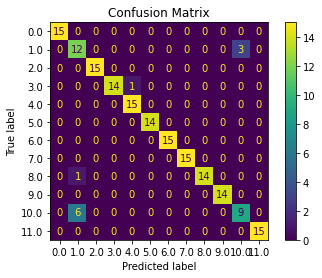

In [ ]:
if(len(np.unique(test_Y))) == 2:
  # if it is binary classification, you will get a precision, recall and f1_score for each of the labels
  result = evaluate(train_X, test_X, train_Y, test_Y, agent=solution.best_agent, classifier='knn', save_conf_mat=True)
else:  
  # for a multi-class problem, you will get a avreaged precision, recall and f1_score
  # Options for averaging:
  # 1. macro
  # 2. weighted
  # 3. samples
  result = evaluate(train_X, test_X, train_Y, test_Y, agent=solution.best_agent, classifier='knn', save_conf_mat=True, averaging="weighted")

In [ ]:
result.predictions

In [ ]:
result.accuracy

0.9382022471910112

In [ ]:
result.recall

0.9382022471910112

In [ ]:
result.precision

0.9426190124186871

In [ ]:
result.f1_score

0.9385948402682867

In [ ]:
result.confusion_matrix